In [17]:
import os
from io import BytesIO
from skimage import io
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import urllib.request
import urllib.parse
import mapbox_vector_tile
import xml.etree.ElementTree as xmlet
import lxml.etree as xmltree
from PIL import Image as plimg
import numpy as np
from owslib.wms import WebMapService
from IPython.display import Image, display
%matplotlib inline

In [26]:
# Construct capability URL.
wmsUrl = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
SERVICE=WMS&REQUEST=GetCapabilities'

# Request WMS capabilities.
response = requests.get(wmsUrl)

# Display capabilities XML in original format. Tag and content in one line.
WmsXml = xmltree.fromstring(response.content)

# Display capabilities XML in pretty format.
print(xmltree.tostring(WmsXml, pretty_print=True).decode('utf-8'))

<WMS_Capabilities xmlns="http://www.opengis.net/wms" xmlns:sld="http://www.opengis.net/sld" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:ms="http://mapserver.gis.umn.edu/mapserver" version="1.3.0" xsi:schemaLocation="http://www.opengis.net/wms http://schemas.opengis.net/wms/1.3.0/capabilities_1_3_0.xsd  http://www.opengis.net/sld http://schemas.opengis.net/sld/1.1.0/sld_capabilities.xsd  http://mapserver.gis.umn.edu/mapserver https://gitc.earthdata.nasa.gov/wms/epsg4326/best/?service=WMS&amp;version=1.3.0&amp;request=GetSchemaExtension">
<Service>
  <Name>WMS</Name>
  <Title>NASA Global Imagery Browse Services for EOSDIS WMS (EPSG:4326 / best)</Title>
  <Abstract>The Global Imagery Browse Services (GIBS) system is a core EOSDIS component which provides a scalable, responsive, highly available, and community standards based set of imagery services. These services are designed with the goal of advancing user interactions with EOSDIS&#8217; inter-disciplinary data through e

In [23]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.1.1')

print("Connected to GIBS WMS Service")
# flags = ["HLS", "Landsat"]]
# layers = [layer for layer in list(wms.contents) if any(flag in layer for flag in flags)]
for layer in  list(wms.contents): #layers:
    print(f"  {layer}")
    
# Print layers with data for 2024>
print("Layers with data for 2024:")
for layer in layers:
    if "2024" in layer:
        print(f"  {layer}")

Connected to GIBS WMS Service
  Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual
  Landsat_WELD_CorrectedReflectance_Bands157_Global_Monthly
  Landsat_WELD_CorrectedReflectance_Bands743_Global_Annual
  Landsat_WELD_CorrectedReflectance_Bands743_Global_Monthly
  Landsat_WELD_CorrectedReflectance_TrueColor_Global_Annual
  Landsat_WELD_CorrectedReflectance_TrueColor_Global_Monthly
  OPERA_L3_Dynamic_Surface_Water_Extent-HLS
  Landsat_WELD_NDVI_Global_Annual
  Landsat_WELD_NDVI_Global_Monthly
  Landsat_Human_Built-up_And_Settlement_Extent
  Landsat_Global_Man-made_Impervious_Surface
  HLS_L30_Nadir_BRDF_Adjusted_Reflectance
  HLS_S30_Nadir_BRDF_Adjusted_Reflectance
  OrbitTracks_Landsat-7_Ascending
  OrbitTracks_Landsat-7_Ascending_Lines
  OrbitTracks_Landsat-7_Ascending_Points
  OrbitTracks_Landsat-8_Ascending
  OrbitTracks_Landsat-8_Ascending_Lines
  OrbitTracks_Landsat-8_Ascending_Points
  OrbitTracks_Landsat-9_Ascending
  OrbitTracks_Landsat-9_Ascending_Lines
  OrbitTracks_Land

In [24]:
def fetch_and_save_image(wms, layer_name, bbox, size, time, output_path):
    # Configure request for the specified layer
    img = wms.getmap(layers=[layer_name],  # Layers
                     srs='EPSG:4326',  # Map projection
                     bbox=bbox,  # Bounds
                     size=size,  # Image size
                     time=time,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    # Save output PNG to a file
    with open(output_path, 'wb') as out:
        out.write(img.read())

    # View image
    return Image(output_path)

# Example usage
layer_name = 'Landsat_WELD_NDVI_Global_Monthly'
bbox = (-180, -90, 180, 90)
size = (1200, 600)
time = '2024-09-21'
output_path = f'imgs/{layer_name}.png'

fetch_and_save_image(wms, layer_name, bbox, size, time, output_path)

ServiceException: msWMSApplyTime: WMS server error. Time value(s) 2024-09-21 given is invalid or outside the time extent defined (1984-03-01/1986-11-01/P1M,1988-12-01/1991-11-01/P1M,1998-12-01/2001-11-01/P1M), and default time set is invalid (2011-11-01)

In [28]:
# Coverts response to XML tree.
WmsTree = xmlet.fromstring(response.content)

alllayer = []
layerNumber = 0

# Parse XML.
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                alllayer.append(f.text)
                
                layerNumber += 1

print('There are layers: ' + str(layerNumber))

for one in sorted(alllayer):
    print(one)
# print('...')
# for one in sorted(alllayer)[-5:]:
#     print(one)

There are layers: 1255
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night
AIRS_L2_Cloud_Top_Height_Day
AIRS_L2_Cloud_Top_Height_Night
AIRS_L2_Dust_Score_Day
AIRS_L2_Dust_Score_Night
AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Day
AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Night
AIRS_L2_RelativeHumidity_500hPa_Day
AIRS_L2_RelativeHumidity_500hPa_Night
AIRS_L2_RelativeHumidity_700hPa_Day
AIRS_L2_RelativeHumidity_700hPa_Night
AIRS_L2_RelativeHumidity_850hPa_Day
AIRS_L2_RelativeHumidity_850hPa_Night
AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Day
AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Night
AIRS_L2_Surface_Air_Temperature_Day
AIRS_L2_Surface_Air_Temperature_Night
AIRS_L2_Surface_Relative_Humidity_Day
AIRS_L2_Surface_Relative_Humidity_Night
AIRS_L2_Surface_Skin_Temperature_Day
AIRS_L2_Surface_Skin_Temperature_Night
AIRS_L2_Temperature_500hPa_Day
AIRS_L2_Temperature_500hPa_Night
AIRS_L2_Temperature_700

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
/home/sguzman/miniforge3/envs/nasa/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


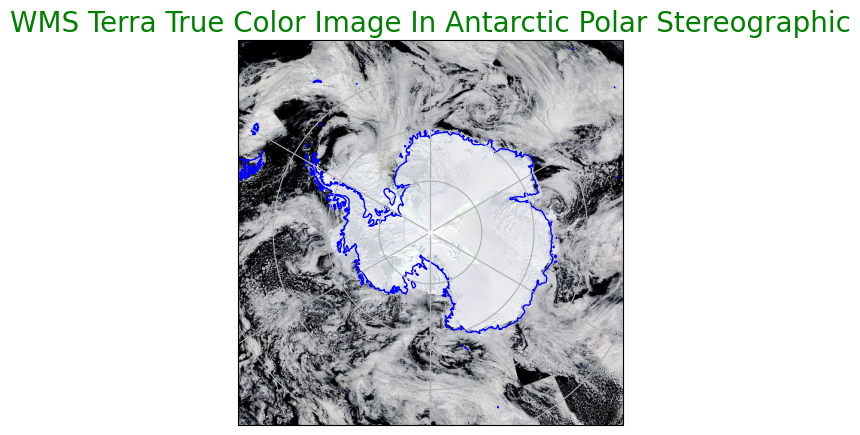

In [115]:
# Construct Antarctic Polar Stereographic project 
proj3031 = 'https://gibs.earthdata.nasa.gov/wms/epsg3031/best/wms.cgi?\
version=1.3.0&service=WMS&request=GetMap&\
format=image/png&STYLE=default&bbox=-4194300,-4194300,4194300,4194300&CRS=EPSG:3031&\
HEIGHT=512&WIDTH=512&TIME=2021-03-01&layers=MODIS_Terra_CorrectedReflectance_TrueColor'

# Request image.
img = io.imread(proj3031) 

# Display image on map.
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.imshow(img, extent = (-4194300,4194300,-4194300,4194300), origin = 'upper')

# Draw coastline and grid.
ax.coastlines(color='blue', linewidth=1)
ax.gridlines()

plt.title('WMS Terra True Color Image In Antarctic Polar Stereographic',\
          fontname = "Times New Roman", fontsize = 20, color = 'green')

plt.show()
 
print('')

In [92]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.1.1')

# # Get the layer names
# for layer in wms.contents:
#     print(layer)
#     print(wms[layer].title)

search_flags = ['HLS', 'Landsat']
layers = [layer for layer in wms.contents if any(flag in wms[layer].title for flag in search_flags)]
print(layers)

['Landsat_WELD_CorrectedReflectance_Bands157_Global_Annual', 'Landsat_WELD_CorrectedReflectance_Bands157_Global_Monthly', 'Landsat_WELD_CorrectedReflectance_Bands743_Global_Annual', 'Landsat_WELD_CorrectedReflectance_Bands743_Global_Monthly', 'Landsat_WELD_CorrectedReflectance_TrueColor_Global_Annual', 'Landsat_WELD_CorrectedReflectance_TrueColor_Global_Monthly', 'OPERA_L3_Dynamic_Surface_Water_Extent-HLS', 'Landsat_WELD_NDVI_Global_Annual', 'Landsat_WELD_NDVI_Global_Monthly', 'Landsat_Human_Built-up_And_Settlement_Extent', 'Landsat_Global_Man-made_Impervious_Surface', 'HLS_L30_Nadir_BRDF_Adjusted_Reflectance', 'HLS_S30_Nadir_BRDF_Adjusted_Reflectance', 'OrbitTracks_Landsat-7_Ascending', 'OrbitTracks_Landsat-7_Ascending_Lines', 'OrbitTracks_Landsat-7_Ascending_Points', 'OrbitTracks_Landsat-8_Ascending', 'OrbitTracks_Landsat-8_Ascending_Lines', 'OrbitTracks_Landsat-8_Ascending_Points', 'OrbitTracks_Landsat-9_Ascending', 'OrbitTracks_Landsat-9_Ascending_Lines', 'OrbitTracks_Landsat-9_Asc

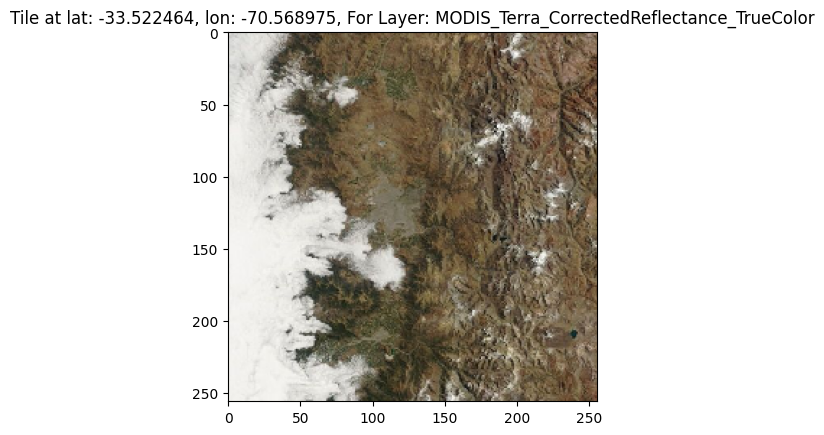

In [ ]:
# Especifica la latitud y longitud deseadas
def get_tile(wms, layer_name):
    latitude = -33.522464  # Ejemplo: latitud de Santiago, Chile (esta coordenada mide el cambio desde el ecuador)
    longitude = -70.568975  # Ejemplo: longitud de Santiago, Chile (esta coordenada mide el cambio desde el meridiano de Greenwich)

    # Define el tamaño del tile
    width = 256
    height = 256
    zoom = 10
    # Calcula las coordenadas del bounding box
    bbox = (longitude - 0.1*zoom, latitude - 0.1*zoom, longitude + 0.1*zoom, latitude + 0.1*zoom)

    # Solicita el tile del servicio WMS
    img = wms.getmap(
        layers=[layer_name],
        srs='EPSG:4326',
        bbox=bbox,
        size=(width, height),
        format='image/png', 
        transparent=True,
        time = '2024-02-14',
    )

    # Muestra la imagen
    image = io.imread(BytesIO(img.read()))
    plt.imshow(image)
    plt.title(f'Tile at lat: {latitude}, lon: {longitude}, For Layer: {layer_name}')
    plt.show()

layer_name = 'MODIS_Terra_CorrectedReflectance_TrueColor'
get_tile(wms, layer_name)

# for l in important_layers:
#     try:
#         get_tile(wms, l)
#     except Exception as e:
#         print(f"Error with layer {l}: {e}")

interactive(children=(FloatSlider(value=-33.522464, description='lat', max=-32.522464, min=-34.522464, step=0.…

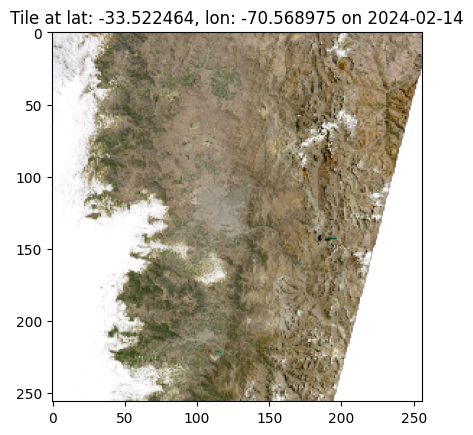

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

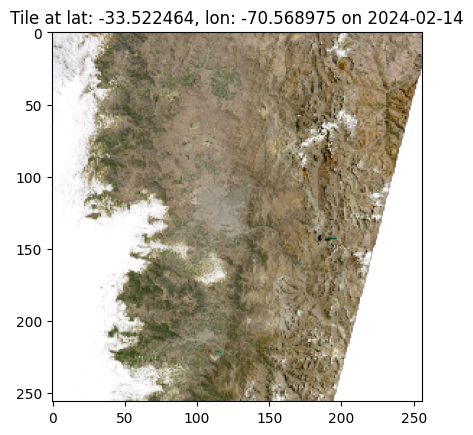

In [16]:
# Crea un widget para ir cambiando la latitud y longitud y mostrar el tile correspondiente
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets
import pandas as pd

layer_names = {
    'HLS_L30_Nadir_BRDF_Adjusted_Reflectance',
    'HLS_L30_Nadir_BRDF_Corrected_TIRS_NDVI',
}
layer_name = 'HLS_L30_Nadir_BRDF_Adjusted_Reflectance'
latitude = -33.522464
longitude = -70.568975
width = 256
height = 256
zoom = 10

@interact(
    lat=FloatSlider(value=latitude, min=latitude-1, max=latitude+1, step=0.01),
    lon=FloatSlider(value=longitude, min=longitude-1, max=longitude+1, step=0.01),
    zoom=IntSlider(value=10, min=0.1, max=20, step=1),
    date=widgets.DatePicker(value=pd.to_datetime('2024-02-14'))
)
def show_tile(lat, lon, zoom, date):
    lat_base = -33.522464
    lon_base = -70.568975
    
    lat = max(min(lat, lat_base + 1), lat_base - 1)
    lon = max(min(lon, lon_base + 1), lon_base - 1)
    plt.clf()
    bbox = (lon - 0.1*zoom, lat - 0.1*zoom, lon + 0.1*zoom, lat + 0.1*zoom)
    img = wms.getmap(
        layers=[layer_name],
        srs='EPSG:4326',
        bbox=bbox,
        size=(width, height),
        format='image/png',
        transparent=True,
        time=date.strftime('%Y-%m-%d'),
    )
    fig, ax = plt.subplots()
    image = io.imread(BytesIO(img.read()))
    plt.imshow(image)
    plt.title(f'Tile at lat: {lat}, lon: {lon} on {date.strftime("%Y-%m-%d")}')
    return fig
    
# Usar
show_tile(latitude, longitude, zoom, pd.to_datetime('2024-02-14'))

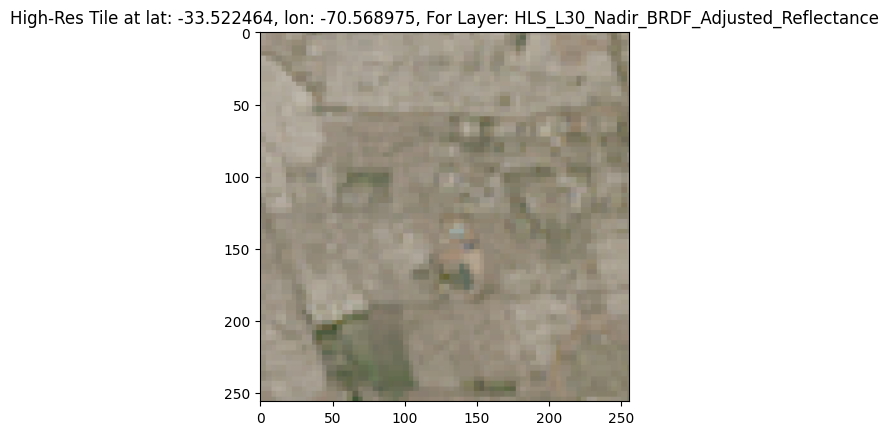

In [111]:
def get_high_res_tile(wms, layer_name, latitude, longitude, zoom, date):
    # Define el tamaño del tile en píxeles
    width = 256
    height = 256
    
    # Calcula el tamaño del bounding box en grados
    bbox_size = 0.1 / zoom
    
    # Calcula las coordenadas del bounding box
    bbox = (longitude - bbox_size, latitude - bbox_size, longitude + bbox_size, latitude + bbox_size)
    
    # Solicita el tile del servicio WMS
    img = wms.getmap(
        layers=[layer_name],
        srs='EPSG:4326',
        bbox=bbox,
        size=(width, height),
        format='image/png',
        transparent=True,
        time=date.strftime('%Y-%m-%d'),
    )
    
    # Muestra la imagen
    image = io.imread(BytesIO(img.read()))
    plt.imshow(image)
    plt.title(f'High-Res Tile at lat: {latitude}, lon: {longitude}, For Layer: {layer_name}')
    plt.show()

# Ejemplo de uso
layer_name = 'HLS_L30_Nadir_BRDF_Adjusted_Reflectance'
latitude = -33.522464
longitude = -70.568975
zoom = 10
date = pd.to_datetime('2024-02-14')

get_high_res_tile(wms, layer_name, latitude, longitude, zoom, date)

In [ ]:
import requests
import matplotlib.pyplot as plt

# Especifica la latitud y longitud deseadas
latitude = -33.522464  # Ejemplo: latitud de Santiago, Chile
longitude = -70.568975  # Ejemplo: longitud de Santiago, Chile

# Define el rango de fechas
start_date = '2024-01-01'
end_date = '2024-12-31'

# Tu API key de la NASA
api_key = ''

# URL de la API de la NASA para obtener los pases de satélites
url = f'https://api.nasa.gov/DONKI/FLR?startDate={start_date}&endDate={end_date}&api_key={api_key}'

# Realiza la solicitud a la API
response = requests.get(url)
data = response.json()

# Filtra los datos para obtener los momentos de paso del satélite Landsat
passes = []
for event in data:
    if 'Landsat' in event['instruments'][0]['displayName']:
        passes.append(event['beginTime'])

# Muestra los momentos de paso
for pass_time in passes:
    print(f'Landsat pass at: {pass_time}')